In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
import rioxarray

# Load the image
data_dir = 'F:/crs/proj/2025_Marconi_maps/Marconi_Products/'
fn = "2025-005-FA_Mar_Marconi_Topobathy_DSM_1m.tif"

def rotrans(x, y, x0, y0, theta):
    '''
    2D rotation and translation of x, y
    Input:
        x, y - row vectors of original coordinates (must be same size)
        x0, y0 - Offset (location of x, y = (0,0) in new coordinate system)
        theta - Angle of rotation (degrees, CCW from x-axis == Cartesian coorinates)
    Returns:
        x_r, y_r - rotated, offset coordinates
    '''
    thetar = np.radians(theta)
    c, s = np.cos(thetar), np.sin(thetar)

    # homogenous rotation matrix
    Rh = np.array(((c, -s,  0.),
                   (s,  c,  0.),
                   (0., 0., 1.)))
    # homogenous translation matrix
    Th = np.array(((1., 0., x0),
                   (0., 1., y0),
                   (0., 0., 1.)))

    # homogenous input x,y
    xyh = np.vstack((x,y,np.ones_like(x)))

    # perform rotation and translation
    xyrh = np.matmul(np.matmul(Th,Rh), xyh)
    x_r = xyrh[0,:]
    y_r = xyrh[1,:]
    return x_r, y_r


def make_grid(name='marconi_local', e0=420080.0, n0=4638320.0,
    xs=0., xend=200., ys=-100., yend=300., dxdy=1., theta=20.):
    """
    Make a rectangular grid to interpolate elevations onto.

    where:
      e0 - UTM Easting of origin [m]
      n0 - UTM Northing of origin [m]
      xs - Start of alongshore axis [m]
      xend - End of alongshore axis [m]
      ys - Start of cross-shore axis [m]
      yend - End of cross-shore axis [m]
      dxdy - grid size (must be isotropic right now) [m]
      theta - rotation CCW from x-axis [deg]
    """
    xlen = (xend - xs)/dxdy
    ylen = (yend - ys)/dxdy
    nx = int((1./dxdy) * xlen)
    ny = int((1./dxdy) * ylen)
    print(nx, ny)

    xcoords = np.linspace(xs+0.5*dxdy,xend-0.5*dxdy,nx)
    ycoords = np.linspace(ys+0.5*dxdy,yend-0.5*dxdy,ny)

    # these will be the coordinates in rotated space
    xrot, yrot = np.meshgrid(xcoords, ycoords, sparse=False, indexing='xy')

    print('make_grid: Shape of xrot, yrot: ',np.shape(xrot),np.shape(yrot))
    shp = np.shape(xrot)
    xu, yu = rotrans(xrot.flatten(), yrot.flatten(), e0, n0, theta)
    xu=np.reshape(xu,shp)
    yu=np.reshape(yu,shp)
    # write the UTM coords of the corners to an ASCII file
    corners = np.asarray(  [[xu[0][0],yu[0][0]],
                           [xu[0][-1],yu[0][-1]],
                           [xu[-1][-1],yu[-1][-1]],
                           [xu[-1][0],yu[-1][0]],
                           [xu[0][0],yu[0][0]]])

    print('corners x, corners y (orig. coords)')
    print(corners)
    fn_corners = name+'.csv'
    print('Saving to '+fn_corners)
    np.savetxt(fn_corners, corners, delimiter=",")
    return nx, ny, xu, yu, xrot, yrot, xcoords, ycoords

# make grids of both original (UTM) and rotated (local) coordinates
nx, ny, xu, yu, xrot, yrot, xcoords, ycoords = make_grid(name='marconi_local', e0=420080.0, n0=4638320.0,
    xs=0., xend=200., ys=-100., yend=300., dxdy=1., theta=10.)

200 400
make_grid: Shape of xrot, yrot:  (400, 200) (400, 200)
corners x, corners y (orig. coords)
[[ 420097.77039755 4638222.09845266]
 [ 420293.7471404  4638256.65444002]
 [ 420224.46151751 4638649.59273347]
 [ 420028.48477467 4638615.03674612]
 [ 420097.77039755 4638222.09845266]]
Saving to marconi_local.csv


In [2]:
da = rioxarray.open_rasterio( data_dir+fn, masked=True )

print( np.shape(np.flipud(da['y'].values)), np.shape(da['x'].values), np.shape( np.flipud(da.values)) )
x = da['x'].values
y = np.flipud(da['y'].values)

# Not sure how da.values got a singleton dimension, but squeeze gets rid of it.
# However, make sure to squeeze before flipping
z = np.flipud(np.squeeze(da.values))
print(np.shape(x),np.shape(y),np.shape(z))

f = interpolate.RegularGridInterpolator( (y, x), z, method='linear')   

# Array for interpolated elevations
zi=np.nan * np.ones((ny,nx))
    
# this is the fast iteration, which only works when all of the source points fall inside the target box
try:
    zi=f((yu,xu))
        # this is a slow iteration through all of the points, but allows us to skip ones that are outside
except:
    if(not iswarned):
        print("Warning: using slow iteration.")
        iswarned = True
    for ij in np.ndindex(zi.shape):
        try:
            zi[ij]=f((yu[ij],xu[ij]))
        except:
            zi[ij]=np.NaN



(1073,) (1298,) (1, 1073, 1298)
(1298,) (1073,) (1073, 1298)


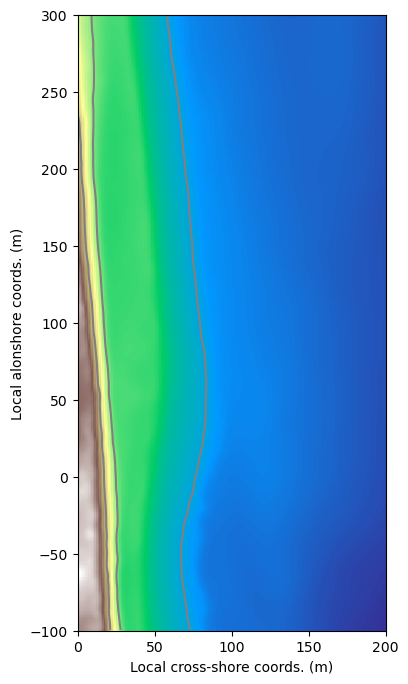

In [3]:
levels = [-10 -5, 0, 5, 10 ]
fig, axes = plt.subplots(1, 1, figsize = (5, 8) )
plt.pcolormesh( xrot, yrot, zi, cmap='terrain' )
plt.contour( xrot, yrot, zi, levels=levels, colors='gray' )
plt.xlabel('Local cross-shore coords. (m)')
plt.ylabel('Local alonshore coords. (m)')
axes.set_aspect( 'equal' )

Text(0, 0.5, 'Elevaton (m NAVD88)')

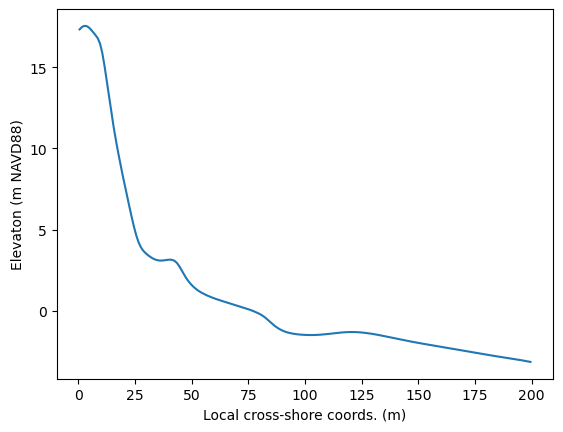

In [4]:
# plot a profile
# find yrot = ~0 (note cell centers are a 0.5 m)
y_index = int( np.argwhere( yrot[:,0]>=0. )[0][0] )
plt.plot( xrot[y_index,:], zi[y_index,:])
plt.xlabel('Local cross-shore coords. (m)')
plt.ylabel('Elevaton (m NAVD88)')